In [448]:
import torch
import gzip, pickle, matplotlib as mpl
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

mpl.rcParams['image.cmap'] = 'gray'

In [3]:
data = None
with gzip.open('data/mnist.pkl.gz', 'rb') as f:
    data = pickle.load(f, encoding='latin')
((x_train, y_train), (x_val, y_val), _) = data
(x_train, y_train, x_val, y_val) = map(torch.tensor, (x_train, y_train, x_val, y_val))
x_train.shape, y_train.shape, x_val.shape, y_val.shape

(torch.Size([50000, 784]),
 torch.Size([50000]),
 torch.Size([10000, 784]),
 torch.Size([10000]))

In [4]:
m, n = x_train.shape
c = max(y_train) + 1
nh = 50

In [5]:
class Model(nn.Module):
    def __init__(self, nin, nh, nout):
        super().__init__()
        self.l1 = nn.Linear(nin, nh)
        self.relu = nn.ReLU(nh)
        self.l2 = nn.Linear(nh, nout)
    
    def __call__(self, x):
        return self.l2(self.relu(self.l1(x))) 

In [55]:
class Model(nn.Module):
    def __init__(self, nin, nh, nout):
        super().__init__()
        self.layers = [nn.Linear(nin, nh), nn.ReLU(nh), nn.Linear(nh, nout)]
    
    def __call__(self, x):
        for l in self.layers:
            x = l(x)
        return x

In [56]:
model = Model(n, nh, 10)
pred = model(x_train)
pred.shape

torch.Size([50000, 10])

In [7]:
for p in model.parameters():
    print(p.nelement(), p.shape)

39200 torch.Size([50, 784])
50 torch.Size([50])
500 torch.Size([10, 50])
10 torch.Size([10])


In [8]:
print('total parms', sum(p.nelement() for p in model.parameters()))

total parms 39760


In [9]:
def logsoftmax(x):
    return (x.exp() / x.exp().sum(1, keepdim=True)).log()

In [10]:
logsoftmax(pred)[2].sum()

tensor(-23.0927, grad_fn=<SumBackward0>)

In [11]:
def logsoftmax(x):
    return x - (x.exp().sum(1, keepdim=True)).log()

In [12]:
logsoftmax(pred)[2].sum()

tensor(-23.0927, grad_fn=<SumBackward0>)

In [13]:
def logsumexp(x):
    m = x.max(1, keepdim=True)[0]
    return m + (x - m).exp().sum(1, keepdim=True).log()

In [14]:
def logsoftmax(x):
    return x - logsumexp(x)

In [15]:
logsoftmax(pred)[2].sum()

tensor(-23.0927, grad_fn=<SumBackward0>)

In [16]:
torch.allclose(logsumexp(pred), pred.logsumexp(1, keepdim=True))

True

In [18]:
pred.logsumexp(1).shape

torch.Size([50000])

In [20]:
logsumexp(pred).shape

torch.Size([50000, 1])

In [21]:
sm_pred = logsoftmax(pred)

In [22]:
sm_pred

tensor([[-2.3406, -2.2055, -2.4671,  ..., -2.1197, -2.1925, -2.3841],
        [-2.3533, -2.1488, -2.4590,  ..., -2.1886, -2.3319, -2.4022],
        [-2.4046, -2.1510, -2.4842,  ..., -2.1441, -2.2718, -2.4118],
        ...,
        [-2.3200, -2.2199, -2.4430,  ..., -2.1947, -2.3111, -2.3752],
        [-2.3264, -2.2229, -2.5810,  ..., -2.1244, -2.2065, -2.3338],
        [-2.3331, -2.1562, -2.5707,  ..., -2.1711, -2.2588, -2.4073]],
       grad_fn=<SubBackward0>)

In [29]:
sm_pred[[0, 1, 2], [1, 2, 3]]

tensor([-2.2055, -2.4590, -2.2582], grad_fn=<IndexBackward0>)

In [30]:
def nll(input, target):
    return -input[range(target.shape[0]), target].mean()

In [32]:
loss = nll(sm_pred, y_train)
loss

tensor(2.3128, grad_fn=<NegBackward0>)

In [35]:
F.nll_loss(sm_pred, y_train)

tensor(2.3128, grad_fn=<NllLossBackward0>)

In [36]:
F.cross_entropy(sm_pred, y_train)

tensor(2.3128, grad_fn=<NllLossBackward0>)

In [37]:
loss_func = F.cross_entropy

In [38]:
bs = 50
xb = x_train[:bs]
preds = model(xb)
preds.shape

torch.Size([50, 10])

In [39]:
preds[0]

tensor([-0.0447,  0.0904, -0.1712, -0.0633, -0.0685, -0.1044,  0.0481,  0.1762,
         0.1034, -0.0882], grad_fn=<SelectBackward0>)

In [40]:
yb = y_train[:bs]

In [41]:
yb

tensor([5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5, 3, 6, 1, 7, 2, 8, 6, 9, 4, 0, 9, 1,
        1, 2, 4, 3, 2, 7, 3, 8, 6, 9, 0, 5, 6, 0, 7, 6, 1, 8, 7, 9, 3, 9, 8, 5,
        9, 3])

In [44]:
preds.argmax(1)

tensor([7, 1, 7, 6, 7, 1, 7, 7, 1, 7, 7, 6, 0, 7, 1, 1, 7, 7, 7, 7, 1, 7, 7, 6,
        7, 7, 7, 7, 1, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 1, 7, 1, 7, 1, 7,
        1, 7])

In [51]:
loss = loss_func(preds, yb)

In [45]:
def accuracy(out, target):
    return (out.argmax(1) == target).float().mean()

In [46]:
accuracy(preds, yb)

tensor(0.0800)

In [47]:
lr = 0.5
epochs = 3

In [49]:
def report(loss, preds, target):
    print(f'loss: {loss:.2f}, accuracy:{accuracy(preds, target):.2f}')

In [52]:
report(loss, preds, yb)

loss: 2.31, accuracy:0.08


In [53]:
xb, yb = x_train[:bs], y_train[:bs]
preds = model(xb)
report(loss_func(preds, yb), preds, yb)

loss: 2.31, accuracy:0.08


In [57]:
for epoch in range(epochs):
    for i in range(0, m, bs):
        s = slice(i, min(m, i+bs))
        xb,yb = x_train[s], y_train[s]
        preds = model(xb)
        loss = loss_func(preds, yb)
        loss.backward()
        with torch.no_grad():
            for l in model.layers:
                if hasattr(l, 'weight'):
                    l.weight -= lr * l.weight.grad
                    l.bias -= lr * l.bias.grad
                    l.weight.grad.zero_()
                    l.bias.grad.zero_()
    report(loss, preds, yb)

loss: 0.16, accuracy:0.96
loss: 0.14, accuracy:0.94
loss: 0.09, accuracy:0.98


In [62]:
m1 = nn.Module()

In [63]:
m1

Module()

In [64]:
m1.foo = 'hey'

In [65]:
m1

Module()

In [66]:
m1.foo = nn.Linear(2, 3)

In [72]:
m1.boo = nn.Linear(3, 1)

In [73]:
m1

Module(
  (foo): Linear(in_features=2, out_features=3, bias=True)
  (boo): Linear(in_features=3, out_features=1, bias=True)
)

In [75]:
list(m1.named_children())

[('foo', Linear(in_features=2, out_features=3, bias=True)),
 ('boo', Linear(in_features=3, out_features=1, bias=True))]

In [76]:
list(m1.named_parameters())

[('foo.weight',
  Parameter containing:
  tensor([[ 0.5799, -0.3588],
          [ 0.0125,  0.1845],
          [ 0.6554, -0.0516]], requires_grad=True)),
 ('foo.bias',
  Parameter containing:
  tensor([-0.4386, -0.1942, -0.0073], requires_grad=True)),
 ('boo.weight',
  Parameter containing:
  tensor([[ 0.1397,  0.2009, -0.1524]], requires_grad=True)),
 ('boo.bias',
  Parameter containing:
  tensor([0.4252], requires_grad=True))]

In [100]:
class MLP(nn.Module):
    def __init__(self, nin, nh, nout):
        super().__init__()
        self.l1 = nn.Linear(nin, nh)
        self.relu = nn.ReLU(nh)
        self.l2 = nn.Linear(nh, nout)
    
    def forward(self, x):
        return self.l2(self.relu(self.l1(x)))

In [101]:
model = MLP(n, nh, 10)

In [102]:
model.l1

Linear(in_features=784, out_features=50, bias=True)

In [103]:
for name, l in model.named_children():
    print(name, l)

l1 Linear(in_features=784, out_features=50, bias=True)
relu ReLU(inplace=True)
l2 Linear(in_features=50, out_features=10, bias=True)


In [104]:
for p in model.parameters():
    print(p.shape)

torch.Size([50, 784])
torch.Size([50])
torch.Size([10, 50])
torch.Size([10])


In [106]:
def fit():
    for epoch in range(epochs):
        for i in range(0, m, bs):
            s = slice(i, min(m, i+bs))
            xb,yb = x_train[s], y_train[s]
            preds = model(xb)
            loss = loss_func(preds, yb)
            loss.backward()
            with torch.no_grad():
                for p in model.parameters():
                    p -= p.grad * lr
                model.zero_grad()
        report(loss, preds, yb)

In [107]:
fit()

loss: 0.14, accuracy:0.96
loss: 0.05, accuracy:1.00
loss: 0.07, accuracy:0.98


In [168]:
class MyModule():
    def __init__(self, nin, nh, nout):
        self._modules = {}
        self.l1 = nn.Linear(nin, nh)
        self.relu = nn.ReLU(nh)
    
    def __setattr__(self, k, v):
        if not k.startswith('_'):
            self._modules[k] = v
        super().__setattr__(k, v)
        
    def __repr__(self):
        return f'{self._modules}'
    
    def parameters(self):
        for l in self._modules.values():
            yield from l.parameters()

In [169]:
md1 = MyModule(n, nh, 10)

In [170]:
md1

{'l1': Linear(in_features=784, out_features=50, bias=True), 'relu': ReLU(inplace=True)}

In [172]:
for p in md1.parameters():
    print(p.shape)

torch.Size([50, 784])
torch.Size([50])


In [173]:
layers = [nn.Linear(n, nh), nn.ReLU(nh), nn.Linear(nh, 10)]

In [177]:
class Model(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = layers
        for i, l in enumerate(self.layers):
            self.add_module(f'layer_{i}', l)
    
    def forward(self, x):
        for l in self.layers:
            x = l(x)
        return x

In [178]:
model = Model(layers)

In [179]:
model

Model(
  (layer_0): Linear(in_features=784, out_features=50, bias=True)
  (layer_1): ReLU(inplace=True)
  (layer_2): Linear(in_features=50, out_features=10, bias=True)
)

In [180]:
sum(p.nelement() for p in model.parameters())

39760

In [182]:
model(xb).shape

torch.Size([50, 10])

In [183]:
class Model(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = nn.ModuleList(layers)
    
    def forward(self, x):
        for l in self.layers:
            x = l(x)
        return x

In [184]:
model = Model(layers)

In [185]:
model

Model(
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=50, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=50, out_features=10, bias=True)
  )
)

In [186]:
sum(p.nelement() for p in model.parameters())

39760

In [187]:
model = nn.Sequential(*layers)

In [190]:
model

Sequential(
  (0): Linear(in_features=784, out_features=50, bias=True)
  (1): ReLU(inplace=True)
  (2): Linear(in_features=50, out_features=10, bias=True)
)

In [191]:
sum(p.nelement() for p in model.parameters())

39760

In [225]:
class Optimizer:
    def __init__(self, params, lr):
        self.params,self.lr = list(params), lr
    
    def step(self):
        with torch.no_grad():
            for p in self.params:
                p -= p.grad * self.lr
    
    def zero_grad(self):
        for p in self.params:
            p.grad.data.zero_()

In [226]:
model = nn.Sequential(*[nn.Linear(n, nh), nn.ReLU(nh), nn.Linear(nh, 10)])

In [227]:
optim = Optimizer(model.parameters(), lr)

In [228]:
for epoch in range(epochs):
    for i in range(0, m, bs):
        s = slice(i, min(m, i+bs))
        xb,yb = x_train[s], y_train[s]
        preds = model(xb)
        loss = loss_func(preds, yb)
        loss.backward()
        optim.step()
        optim.zero_grad()
    report(loss, preds, yb)

loss: 0.21, accuracy:0.90
loss: 0.13, accuracy:0.94
loss: 0.09, accuracy:0.96


In [229]:
from torch import optim

In [256]:
def get_model():
    model = nn.Sequential(*[nn.Linear(n, nh), nn.ReLU(nh), nn.Linear(nh, 10)])
    return model, optim.SGD(model.parameters(), lr=lr)

In [233]:
model, opt = get_model()

In [235]:
for epoch in range(epochs):
    for i in range(0, m, bs):
        s = slice(i, min(m, i+bs))
        xb,yb = x_train[s], y_train[s]
        preds = model(xb)
        loss = loss_func(preds, yb)
        loss.backward()
        opt.step()
        opt.zero_grad()
    report(loss, preds, yb)

loss: 0.10, accuracy:0.96
loss: 0.04, accuracy:1.00
loss: 0.03, accuracy:1.00


In [242]:
class Dataset:
    def __init__(self, x, y):
        self.x, self.y = x, y
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [253]:
train_ds, val_ds = Dataset(x_train, y_train), Dataset(x_val, y_val)
assert len(x_train) == len(train_ds)
assert len(x_val) == len(val_ds)

In [260]:
model, opt = get_model()

In [261]:
for epoch in range(epochs):
    for i in range(0, m, bs):
        s = slice(i, min(m, i+bs))
        xb, yb = train_ds[s]
        preds = model(xb)
        loss = loss_func(preds, yb)
        loss.backward()
        opt.step()
        opt.zero_grad()
    report(loss, preds, yb)

loss: 0.13, accuracy:0.94
loss: 0.08, accuracy:0.98
loss: 0.13, accuracy:0.96


In [263]:
class DataLoader:
    def __init__(self, ds, bs):
        self.ds, self.bs = ds, bs
    
    def __iter__(self):
        for i in range(0, len(self.ds), self.bs):
            yield self.ds[i:i+self.bs]

In [264]:
train_dl = DataLoader(train_ds, bs)
val_dl = DataLoader(val_ds, bs)

In [265]:
xb, yb = next(iter(train_dl))

In [266]:
xb.shape, yb.shape

(torch.Size([50, 784]), torch.Size([50]))

In [267]:
model, opt = get_model()

In [271]:
for epoch in range(epochs):
    for xb, yb in train_dl:
        preds = model(xb)
        loss = loss_func(preds, yb)
        loss.backward()
        opt.step()
        opt.zero_grad()
    report(loss, preds, yb)

loss: 0.01, accuracy:1.00
loss: 0.01, accuracy:1.00
loss: 0.03, accuracy:0.98


In [272]:
import random

In [284]:
class Sampler:
    def __init__(self, ds, shuffle=True):
        self.n, self.shuffle = len(ds), shuffle
    
    def __iter__(self):
        res = list(range(self.n))
        if self.shuffle:
            random.shuffle(res)
        return iter(res)

In [299]:
ss = Sampler(train_ds, shuffle=False)

In [300]:
from itertools import islice

In [301]:
it = iter(ss)

In [302]:
for i in range(5):
    print(next(it))

0
1
2
3
4


In [303]:
list(islice(ss, 5))

[0, 1, 2, 3, 4]

In [304]:
import fastcore.all as fc

In [319]:
class BatchSampler:
    def __init__(self, sampler, bs, drop_last=False):
        fc.store_attr()
        
    def __iter__(self):
        yield from fc.chunked(iter(self.sampler), self.bs, drop_last=self.drop_last)

In [320]:
batches = BatchSampler(ss, 4)

In [321]:
list(islice(iter(batches), 5))

[[0, 1, 2, 3],
 [4, 5, 6, 7],
 [8, 9, 10, 11],
 [12, 13, 14, 15],
 [16, 17, 18, 19]]

In [419]:
def collate(b):
    xs, ys = zip(*b)
    return torch.stack(xs), torch.stack(ys)

In [431]:
class DataLoader:
    def __init__(self, ds, batches, collate_f=collate):
        fc.store_attr()
    
    def __iter__(self):
        yield from (self.collate_f(self.ds[i] for i in b) for b in self.batches)
        

In [432]:
train_sampler = BatchSampler(Sampler(train_ds, shuffle=True), bs)
val_sampler = BatchSampler(Sampler(val_ds, shuffle=True), bs)

In [433]:
train_dl = DataLoader(train_ds, batches=train_sampler)
val_dl = DataLoader(val_ds, batches=val_sampler)

In [434]:
model, opt = get_model()

In [435]:
fit()

loss: 0.10, accuracy:0.98
loss: 0.05, accuracy:0.98
loss: 0.03, accuracy:1.00


In [436]:
import torch.multiprocessing as mp

In [442]:
class DataLoader:
    def __init__(self, ds, batches, n_workers=1, collate_f=collate):
        fc.store_attr()
    
    def __iter__(self):
        with mp.Pool(self.n_workers) as ex:
            yield from ex.map(self.ds.__getitem__, iter(self.batches))

In [443]:
train_dl = DataLoader(train_ds, batches=train_sampler)

In [444]:
xb, yb = next(iter(train_dl))

In [445]:
xb.shape, yb.shape

(torch.Size([50, 784]), torch.Size([50]))

(<matplotlib.image.AxesImage at 0x141db39d0>, tensor(6))

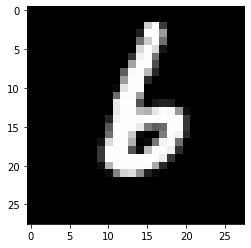

In [452]:
plt.imshow(xb[0].view(28, 28)), yb[0]

In [454]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, BatchSampler

In [456]:
train_samp = BatchSampler(RandomSampler(train_ds), bs, drop_last=False)
val_samp = BatchSampler(SequentialSampler(val_ds), bs, drop_last=False)

In [457]:
train_dl = DataLoader(train_ds, batch_sampler=train_samp, collate_fn=collate)
val_dl = DataLoader(val_ds, batch_sampler=val_samp, collate_fn=collate)

In [458]:
model, opt = get_model()

In [459]:
fit()

loss: 0.12, accuracy:0.96
loss: 0.04, accuracy:0.98
loss: 0.03, accuracy:1.00
